<a href="https://colab.research.google.com/github/pavankalyan066/Natural-Language-Processing/blob/main/Fake_News_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Libraries

In [ ]:
# uncomment to install
# !pip install tensorflow-text

In [60]:
import pandas as pd
import seaborn as sns
import numpy as np
import tensorflow_hub as hub
import tensorflow as tf
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
import tensorflow_hub as hub
import tensorflow_text as text
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

In [2]:
# to unzip the csv file
!unzip /content/drive/MyDrive/NLP/archive.zip 

Archive:  /content/drive/MyDrive/NLP/archive.zip
  inflating: news_articles.csv       


In [41]:
data = pd.read_csv('/content/news_articles.csv')

In [42]:
data.head(2)

,author,published,title,text,language,site_url,main_img_url,type,label,title_without_stopwords,text_without_stopwords,hasImage
0,Barracuda Brigade,2016-10-26T21:41:00.000+03:00,muslims busted they stole millions in govt ben...,print they should pay all the back all the mon...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,Real,muslims busted stole millions govt benefits,print pay back money plus interest entire fami...,1.0
1,reasoning with facts,2016-10-29T08:47:11.259+03:00,re why did attorney general loretta lynch plea...,why did attorney general loretta lynch plead t...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,Real,attorney general loretta lynch plead fifth,attorney general loretta lynch plead fifth bar...,1.0


In [43]:
data['label'].value_counts()

Fake    1294
Real     801
Name: label, dtype: int64

In [44]:
data = data[['title', 'label']]

In [45]:
data.head()

,title,label
0,muslims busted they stole millions in govt ben...,Real
1,re why did attorney general loretta lynch plea...,Real
2,breaking weiner cooperating with fbi on hillar...,Real
3,pin drop speech by father of daughter kidnappe...,Real
4,fantastic trumps point plan to reform healthc...,Real


In [46]:
data['label'] = data['label'].map({'Real': 0, 'Fake':1})

In [47]:
data.tail()

,title,label
2091,teens walk free after gangrape conviction,0.0
2092,school named for munichmassacre mastermind,0.0
2093,russia unveils satan missile,1.0
2094,check out hillarythemed haunted house,1.0
2095,cannabis aficionados develop thca crystalline ...,NaN


In [48]:
data = data.dropna()

In [49]:
data['label'].value_counts()

1.0    1294
0.0     801
Name: label, dtype: int64

We have a approximately 62:38 real:fake news ratio.

Mean Length 61.22673031026253
Min Length 2
Max Length 443


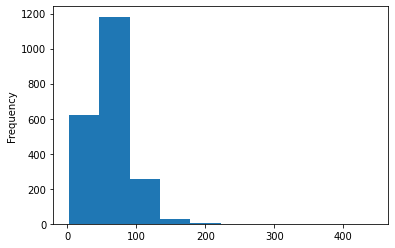

In [50]:
# Character Length of Titles - Min, Mean, Max
print('Mean Length', data['title'].apply(len).mean())
print('Min Length', data['title'].apply(len).min())
print('Max Length', data['title'].apply(len).max())

x = data['title'].apply(len).plot.hist()

We see that that the numbers of characters in each entry ranges from 2–443. There is a high concentration of samples with a length of 0–100. This can be further seen with the mean length in the dataset being approximately 61.

In [ ]:
# Do ot run the below cell for Bert Model

In [61]:
#Import nltk preprocessing library to convert text into a readable format
import nltk
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

#Tokenize the string (create a list -> each index is a word)
data['title'] = data.apply(lambda row: nltk.word_tokenize(row['title']), axis=1)

#Define text lemmatization model (eg: walks will be changed to walk)
lemmatizer = WordNetLemmatizer()

#Loop through title dataframe and lemmatize each word
def lemma(data):
  return [lemmatizer.lemmatize(w) for w in data]

#Apply to dataframe
data['title'] = data['title'].apply(lemma)

#Define all stopwords in the English language (it, was, for, etc.)
stop = stopwords.words('english')

#Remove them from our dataframe
data['title'] = data['title'].apply(lambda x: [i for i in x if i not in stop])

data.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,title,label
0,"[muslim, busted, stole, million, govt, benefit]",0.0
1,"[attorney, general, loretta, lynch, plead, fifth]",0.0
2,"[breaking, weiner, cooperating, fbi, hillary, ...",0.0
3,"[pin, drop, speech, father, daughter, kidnappe...",0.0
4,"[fantastic, trump, point, plan, reform, health...",0.0


In [62]:
#Extracting numpy arrays for the title and classes
titles = data["title"].values
labels = data["label"].values

In [63]:

#Split data into training and testing dataset
title_train, title_test, y_train, y_test = train_test_split(titles, labels, 
                                                            test_size=0.3, 
                                                            random_state=1000)

In [20]:
embed = hub.load("https://tfhub.dev/google/Wiki-words-250/2")

#Convert each series of words to a word2vec embedding
indiv = []
for i in title_train:
  temp = np.array(embed(i))
 
  indiv.append(temp)

#Accounts for different length of words
indiv = tf.keras.preprocessing.sequence.pad_sequences(indiv,dtype='float')
indiv.shape

(1466, 46, 250)

Hence, there are 1466 samples in the training data, the maximum length is 46 words (the ones with less are padded), and each word has 250 features.

In [21]:
test = []

for i in title_test:
  temp = np.array(embed(i))
  test.append(temp)

#Accounts for the different length of words in test data
test = tf.keras.preprocessing.sequence.pad_sequences(test, dtype='float')

- 1 LSTM layer with 50 units
- 2 Dense layers (one with 20 neurons, the second with 5) with a ReLU activation function
- 1 Dense output layer with a sigmoid activation function


In [23]:
#Sequential model has a 50 cell LSTM layer before Dense layers
model = tf.keras.models.Sequential()


model.add(tf.keras.layers.LSTM(50))
model.add(tf.keras.layers.Dense(20,activation='relu'))
model.add(tf.keras.layers.Dense(5,activation='relu'))

model.add(tf.keras.layers.Dense(1,activation='sigmoid'))

#Compile model with binary_crossentropy loss, Adam optimizer, and accuracy metrics
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-4),\
              loss="binary_crossentropy", metrics=['accuracy'])

#Train model on 10 epochs
model.fit(indiv, y_train,validation_data=[test,y_test], epochs=20)

Epoch 1/20
46/46 [==============================] - 5s 52ms/step - loss: 0.6929 - accuracy: 0.5321 - val_loss: 0.6907 - val_accuracy: 0.5739
Epoch 2/20
46/46 [==============================] - 1s 31ms/step - loss: 0.6861 - accuracy: 0.6139 - val_loss: 0.6843 - val_accuracy: 0.6041
Epoch 3/20
46/46 [==============================] - 1s 30ms/step - loss: 0.6766 - accuracy: 0.6201 - val_loss: 0.6745 - val_accuracy: 0.6121
Epoch 4/20
46/46 [==============================] - 1s 31ms/step - loss: 0.6636 - accuracy: 0.6201 - val_loss: 0.6636 - val_accuracy: 0.6121
Epoch 5/20
46/46 [==============================] - 1s 31ms/step - loss: 0.6546 - accuracy: 0.6201 - val_loss: 0.6603 - val_accuracy: 0.6121
Epoch 6/20
46/46 [==============================] - 1s 31ms/step - loss: 0.6494 - accuracy: 0.6201 - val_loss: 0.6560 - val_accuracy: 0.6121
Epoch 7/20
46/46 [==============================] - 1s 31ms/step - loss: 0.6449 - accuracy: 0.6201 - val_loss: 0.6545 - val_accuracy: 0.6153
Epoch 8/20
46

# Dense Layered Model

In [64]:
#Create a word2vec model
vec = Word2Vec(min_count=1)

#Build its vocabulary by looping through the title dataset
vec.build_vocab([x for x in data['title'].values])

#Print the vocabulary size
print(len(vec.wv.vocab))

#Train our word2vec model on all titles for 5 epochs
vec.train([x for x in data['title'].values],total_examples=vec.corpus_count,epochs=5)

5308


(71133, 75985)

In [65]:
#Add a tag which denotes a new document everytime a new dataset is seen
#Example: [[word1,word2,word3,word4],document0]
tags = [TaggedDocument(doc, [i]) for i, doc in enumerate(title_train)]

#Define the Doc2Vec model
doc = Doc2Vec(tags,vector_size=100,min_count=1,epochs=5)
#Build the vocabulary based on the tag structures defined above
#doc.build_vocab(tags)
#Train the doc2vec model
doc.train(tags, total_examples=doc.corpus_count,epochs=doc.epochs)

In [66]:
print(len(doc.wv.vocab))

4290


In [67]:
train_vectors = [doc.infer_vector(i) for i in title_train]

In [68]:
test_vectors = [doc.infer_vector(i) for i in title_test]

In [69]:
train_vectors = np.array(train_vectors)
test_vectors = np.array(test_vectors)

In [70]:
train_vectors.shape

(1466, 100)

In [71]:
#Sequential model
model = tf.keras.Sequential()

#Dense layer - 128 units -input shape is for the 100 vector length, relu activation
model.add(tf.keras.layers.Dense(128,input_shape=[100],activation='relu'))
#'Turn off' half the neurons (reduce overfitting - model will not memorize data and will understand patterns)
model.add(tf.keras.layers.Dropout(0.5))
#Dense layer - 64 units, relu activation
model.add(tf.keras.layers.Dense(64,activation='relu'))
#Dense layer - 32 units, relu activation
model.add(tf.keras.layers.Dense(32,activation='relu'))
#Dense layer - 16 units, relu activation
model.add(tf.keras.layers.Dense(16,activation='relu'))
#Dense layer - 1 units, sigmoid activation
#Binary problem - probability of 1 class - derived with sigmoid
model.add(tf.keras.layers.Dense(1,activation='sigmoid'))

#Train on Adam optimizer with 1e-4 learning rate, loss of binary crossentropy, accuracy tracked
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-4),loss="binary_crossentropy", metrics=['accuracy'])

#Train on training set, test on testing set, for 5 epochs
model.fit(train_vectors,y_train,validation_data=[test_vectors,y_test], epochs= 15)

#Show model architecture
model.summary()

Epoch 1/15
46/46 [==============================] - 1s 8ms/step - loss: 0.6904 - accuracy: 0.6201 - val_loss: 0.6880 - val_accuracy: 0.6121
Epoch 2/15
46/46 [==============================] - 0s 4ms/step - loss: 0.6837 - accuracy: 0.6201 - val_loss: 0.6810 - val_accuracy: 0.6121
Epoch 3/15
46/46 [==============================] - 0s 4ms/step - loss: 0.6761 - accuracy: 0.6201 - val_loss: 0.6740 - val_accuracy: 0.6121
Epoch 4/15
46/46 [==============================] - 0s 4ms/step - loss: 0.6687 - accuracy: 0.6201 - val_loss: 0.6697 - val_accuracy: 0.6121
Epoch 5/15
46/46 [==============================] - 0s 4ms/step - loss: 0.6653 - accuracy: 0.6201 - val_loss: 0.6682 - val_accuracy: 0.6121
Epoch 6/15
46/46 [==============================] - 0s 4ms/step - loss: 0.6639 - accuracy: 0.6201 - val_loss: 0.6681 - val_accuracy: 0.6121
Epoch 7/15
46/46 [==============================] - 0s 4ms/step - loss: 0.6637 - accuracy: 0.6201 - val_loss: 0.6682 - val_accuracy: 0.6121
Epoch 8/15
46/46 [==

# BERT

In [56]:
from sklearn.model_selection import train_test_split

#Split data into training and testing dataset
title_train, title_test, y_train, y_test = train_test_split(titles, labels, test_size=0.2,\
                                                            random_state=1000)

In [26]:
#Use the bert preprocesser and bert encoder from tensorflow_hub
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4')

- 1 Input layer: This will represent the sentence that will be passed into the model).
- The bert_preprocess layer: Here we pass in our input to preprocess the text.
The bert_encoder layer: Here we pass the preprocessed tokens into the BERT encoder.
- 1 Dropout layer with a rate of 0.2. The pooled_output of the BERT encoder is passed into it (more on this below)
- 2 Dense layers with 10 and 1 neurons respectively. The first one will use a ReLU activation function, and the second will use sigmoid.

In [27]:
import tensorflow as tf

# Input Layers
input_layer = tf.keras.layers.Input(shape=(), dtype=tf.string, name='news')

# BERT layers
processed = bert_preprocess(input_layer)
output = bert_encoder(processed)

# Fully Connected Layers
layer = tf.keras.layers.Dropout(0.2, name='dropout')(output['pooled_output'])
layer = tf.keras.layers.Dense(10,activation='relu', name='hidden')(layer)
layer = tf.keras.layers.Dense(1,activation='sigmoid', name='output')(layer)


model = tf.keras.Model(inputs=[input_layer],outputs=[layer])

In [59]:
#Compile model on adam optimizer, binary_crossentropy loss, and accuracy metrics
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
#Train model on 5 epochs
model.fit(title_train, y_train, epochs= 5)

#Evaluate model on test data
model.evaluate(title_test,y_test)

Epoch 1/5
53/53 [==============================] - 730s 14s/step - loss: 0.6705 - accuracy: 0.6086
Epoch 2/5
53/53 [==============================] - 652s 12s/step - loss: 0.6662 - accuracy: 0.6169
Epoch 3/5
53/53 [==============================] - 652s 12s/step - loss: 0.6638 - accuracy: 0.6181
Epoch 4/5
53/53 [==============================] - 651s 12s/step - loss: 0.6612 - accuracy: 0.6187
Epoch 5/5
14/14 [==============================] - 164s 12s/step - loss: 0.6625 - accuracy: 0.6134


[0.662506103515625, 0.6133651733398438]